In [11]:
import sys
sys.path.append("../../helper")
from AnalysisHelper import helper

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [12]:
origin = read_excel("https://data.hossam.kr/E06/covid19_seoul_230531.xlsx")
origin.head()

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2023-05-31,6204277,5987.0,0,NaN,NaN,6492,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,17.0
1,2023-05-30,6198290,3326.0,0,NaN,NaN,6486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,7.0
2,2023-05-29,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
3,2023-05-28,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
4,2023-05-27,6191196,4078.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0


In [13]:
df = origin.filter(['서울시 기준일', '서울시 추가 확진'])
df.rename(columns={'서울시 기준일':'date', '서울시 추가 확진':'confirmed'}, inplace=True)
df.head()

,date,confirmed
0,2023-05-31,5987.0
1,2023-05-30,3326.0
2,2023-05-29,1393.0
3,2023-05-28,1393.0
4,2023-05-27,4078.0


In [14]:
df.dtypes # 날짜가 object type인걸 확인

date          object
confirmed    float64
dtype: object

In [15]:
df['date'] = to_datetime(df['date'].str.strip(), format='%Y-%m-%d')
df.dtypes

date         datetime64[ns]
confirmed           float64
dtype: object

In [17]:
df.isna().sum() # 결측치를 확인하고

date         0
confirmed    1
dtype: int64

In [18]:
df2 = df.fillna(0) # 결측치 삭제
df2.isna().sum()

date         0
confirmed    0
dtype: int64

In [19]:
df3 = helper.set_datetime_index(df2,'date')
df3.head()

,confirmed
2020-02-05,0.0
2020-02-06,0.0
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0


In [20]:
df3.tail() # 데이터의 마지막 n줄을 확인함 

,confirmed
2023-05-27,4078.0
2023-05-28,1393.0
2023-05-29,1393.0
2023-05-30,3326.0
2023-05-31,5987.0


결측치 수: 0


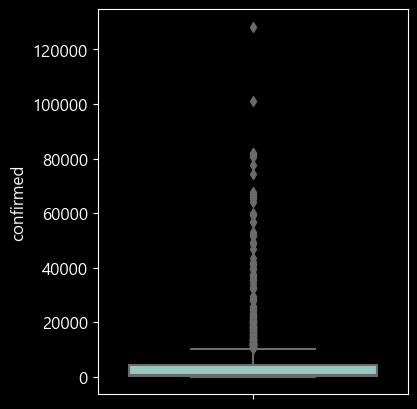

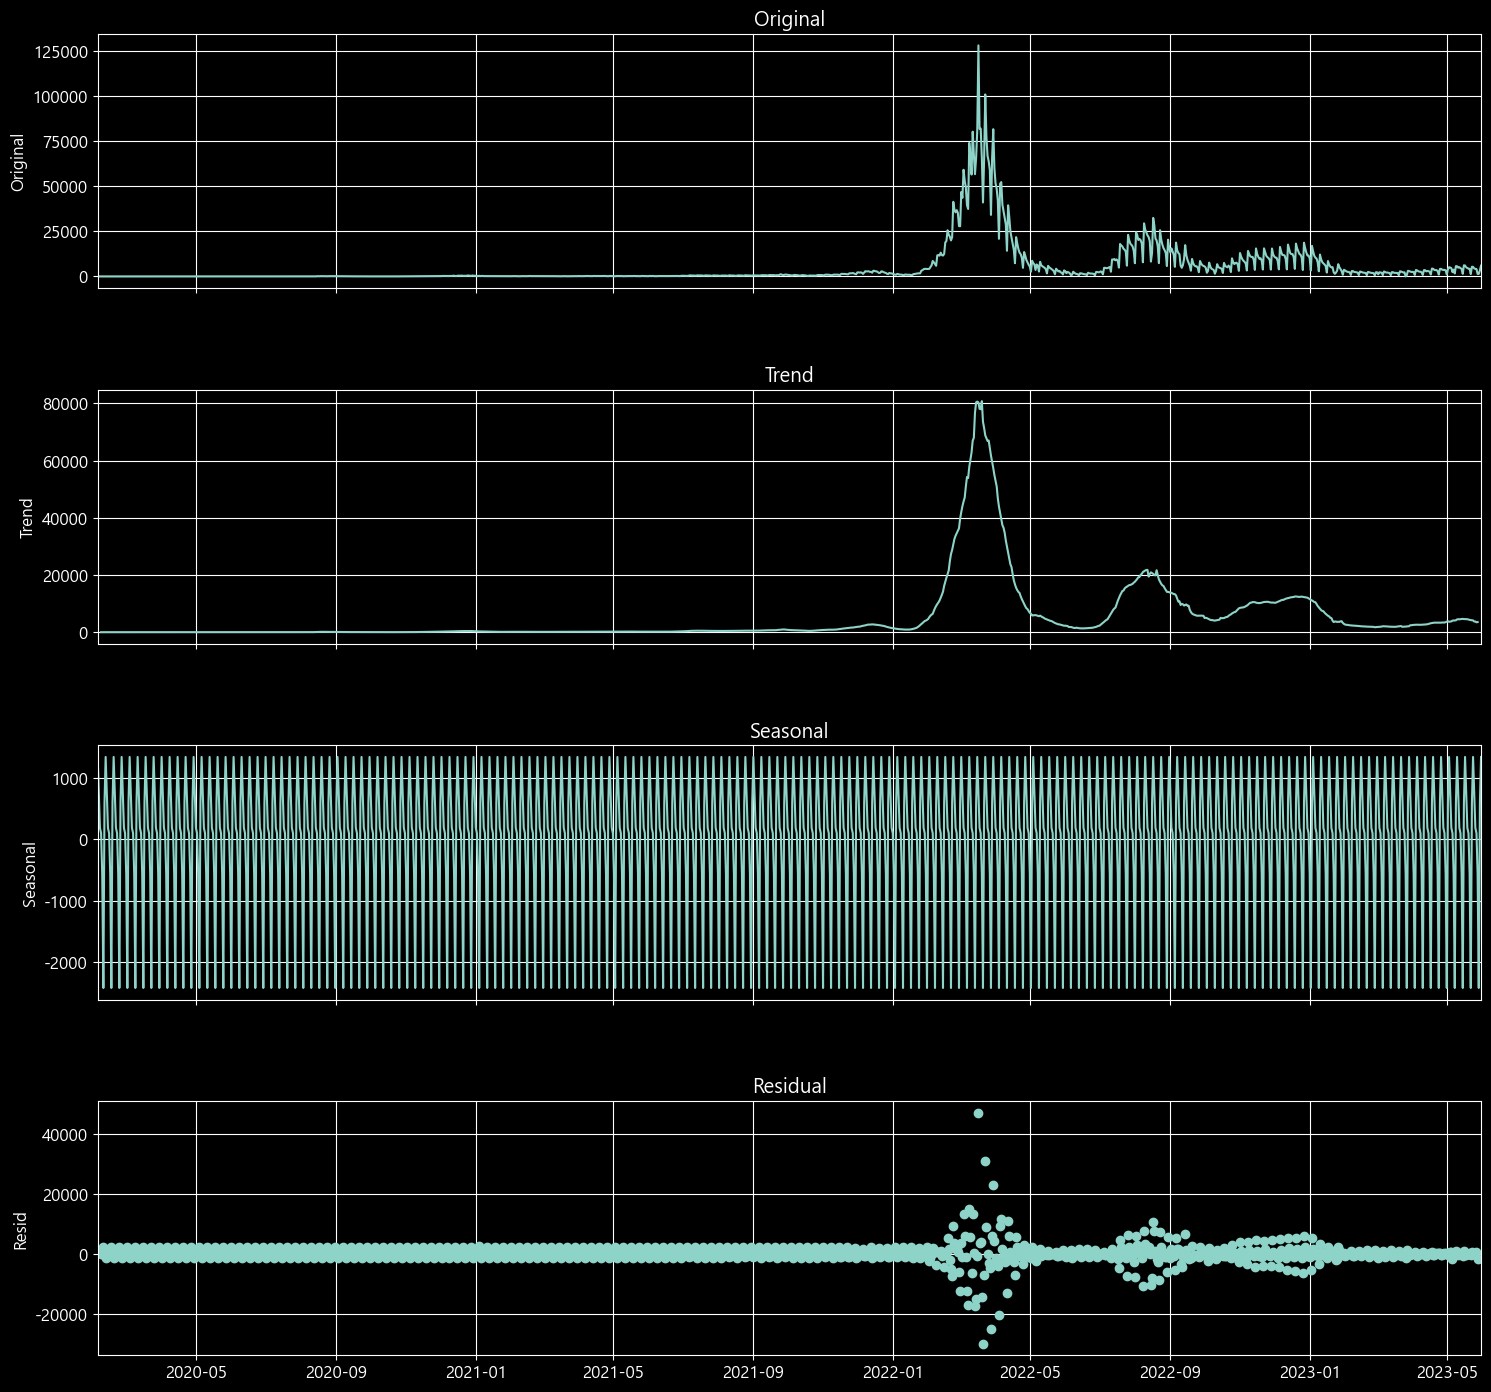

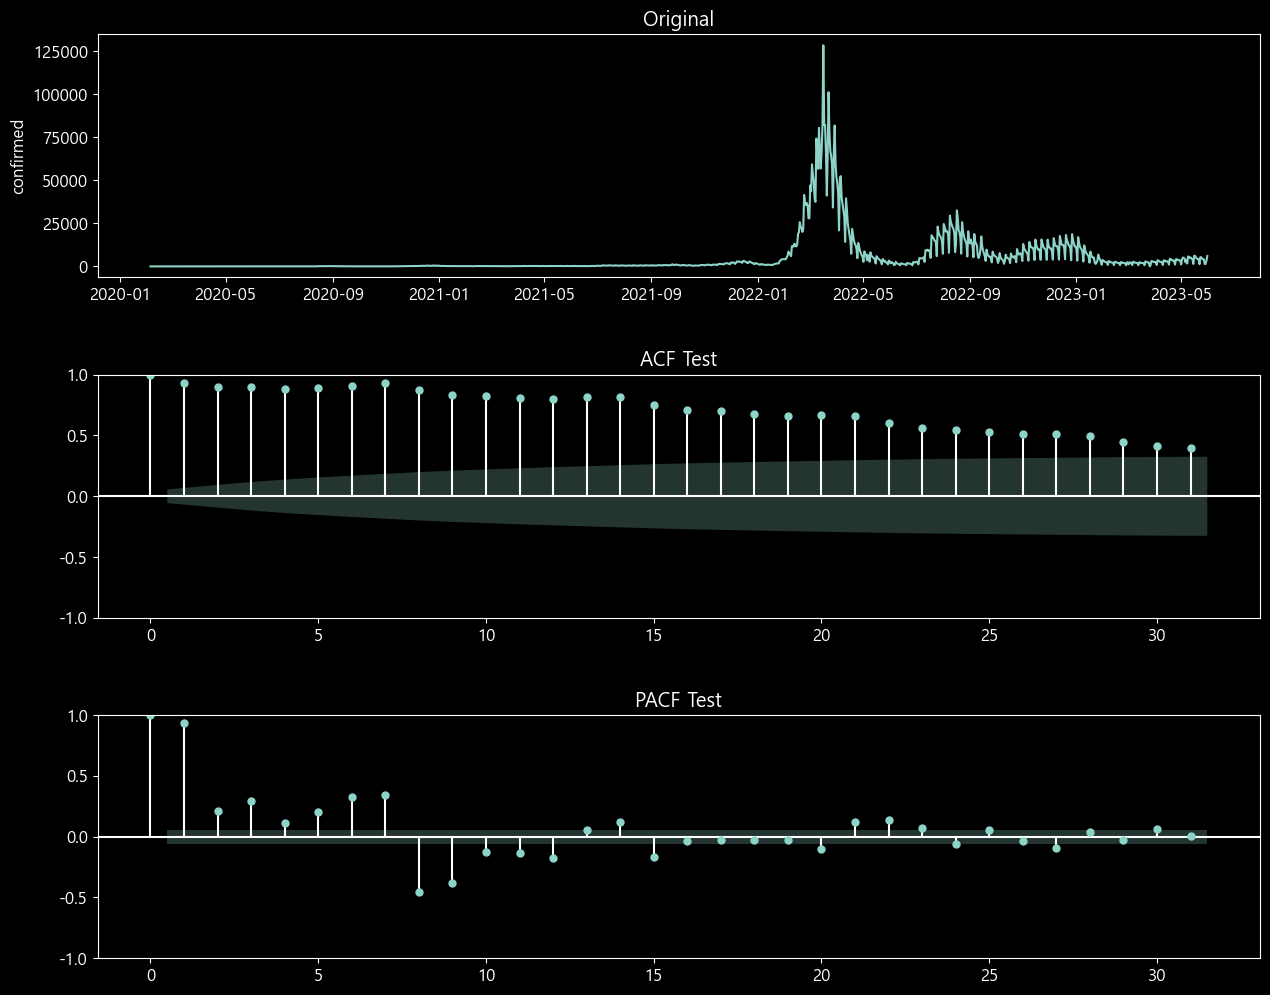

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.11626 |
| 유의수준(p-value)                  | 0.000910279 |
| 최적차수(num of lags)              |          23 |
| 관측치 개수(num of observations)   |        1188 |
| 기각값(Critical Values) 1%         |    -3.43587 |
| 기각값(Critical Values) 5%         |    -2.86398 |
| 기각값(Critical Values) 10%        |    -2.56807 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [21]:
# 데이터 검정
# 이상치는 보이지만 데이터 자체가 실제 발생 데이터이므로 정상 데이터로 판단함.

helper.exp_time_data(data=df3, yname='confirmed',sd_model='a')

In [22]:
model = ARIMA(df3['confirmed'],order=(1,0,0),seasonal_order=(1,0,0,7))
# 코로나가 7일 주기로 요동쳐서
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       confirmed   No. Observations:                 1212
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.350
Date:                         Mon, 07 Aug 2023   AIC                          23152.700
Time:                                 10:56:27   BIC                          23173.100
Sample:                             02-05-2020   HQIC                         23160.381
                                  - 05-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5119.1138   2109.541      2.427      0.015     984.489    9253.738
ar.L1          0.7469      0.006    118.058      0.000     

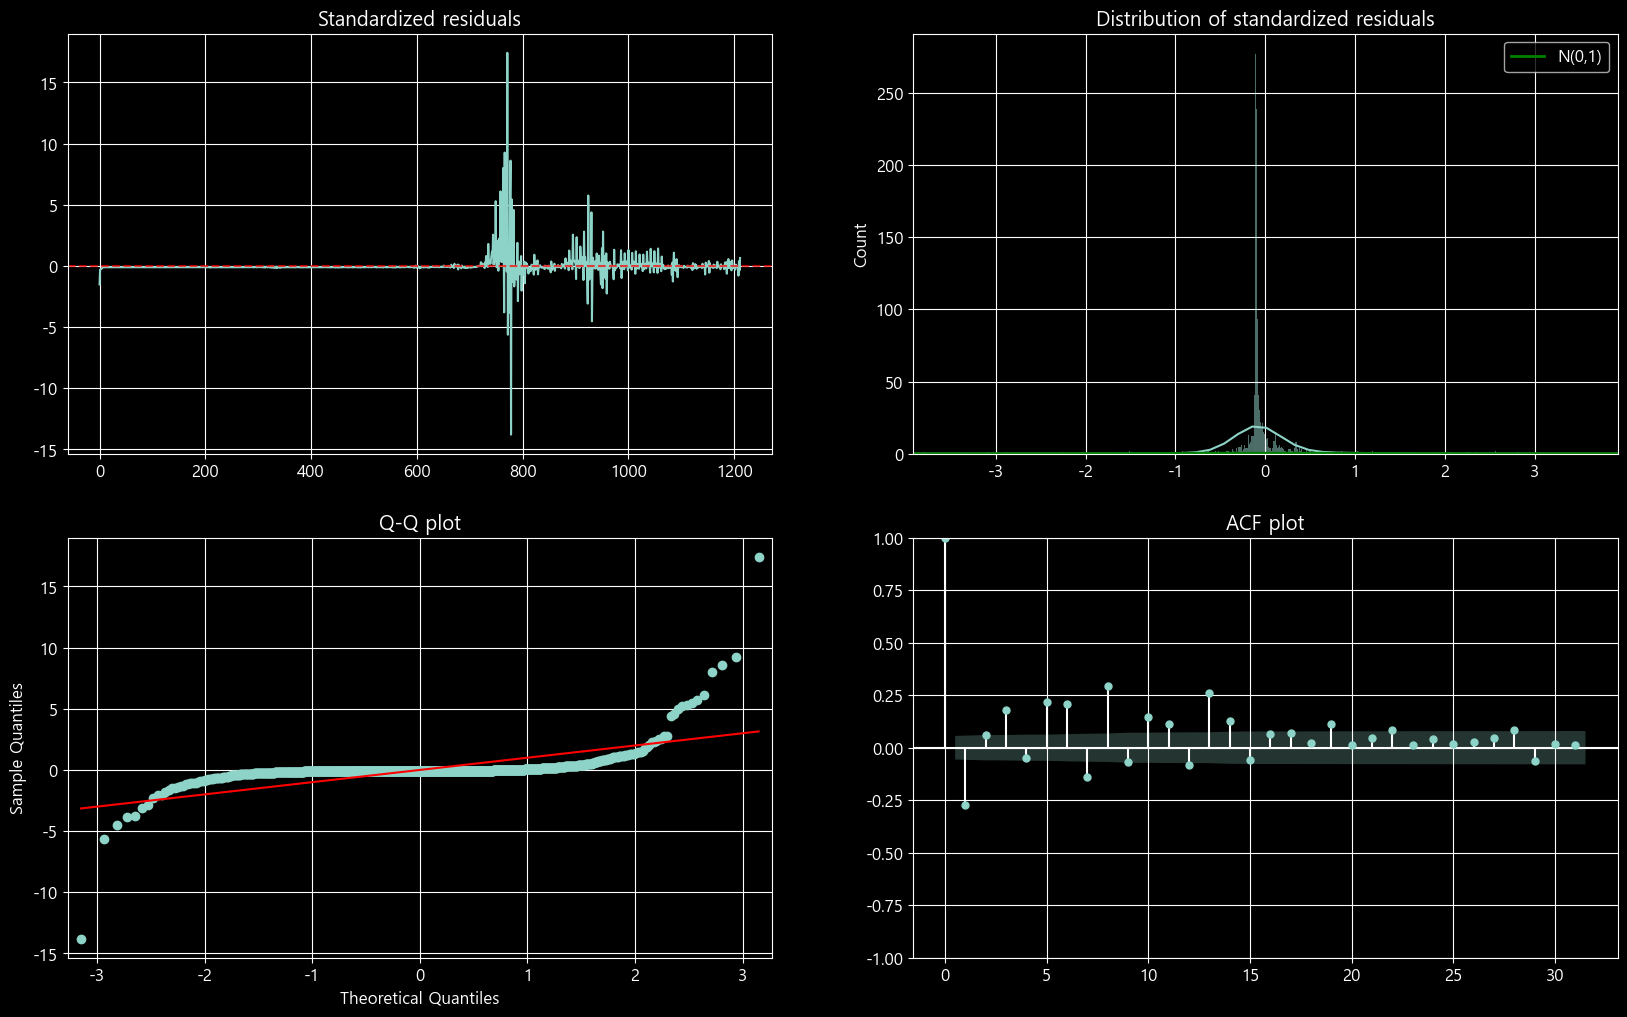

In [23]:
# 잔차분석
helper.arima_diagnostics(fit.resid)

In [25]:
fv = fit.fittedvalues
fv.head()

# fittedvalues 함수는 통계적 시계열 분석에서 모형 적합 결과에서 관측된 데이터의 예측값을 얻기 위해 사용되는 함수입니다. 주로 회귀 분석, ARIMA 모델, SARIMA 모델 등의 시계열 모델에서 자주 사용됩니다.

# fittedvalues 속성을 통해 적합된 값(예측값)을 얻었습니다. 이렇게 얻은 fitted_values는 주어진 모델에 의한 각 관측값에 대한 예측값을 나타냅니다.

# 주의할 점은 fittedvalues는 학습 데이터에 대한 예측값을 제공하는 것이며, 모델을 새로운 데이터에 적용할 때는 predict 함수를 사용해야 합니다.

2020-02-05    5119.113824
2020-02-06    1037.069449
2020-02-07     959.246146
2020-02-08     861.651335
2020-02-09     741.551616
Freq: D, dtype: float64

In [26]:
fc = fit.forecast(30)
fc.head()

# fit.forecast()는 시계열 분석에서 모델 적합 결과를 바탕으로 미래의 값을 예측하는 메서드입니다. 이 메서드는 주로 ARIMA, SARIMA와 같은 시계열 모델에서 사용되며, 이전 데이터를 기반으로 미래 데이터 포인트를 예측하는 데에 활용됩니다.

# fit.forecast(steps)에서 fit은 모델 적합 결과를 나타내며, steps는 미래의 시점을 나타내는 숫자입니다. 즉, steps 개수만큼 미래의 값을 예측하여 반환합니다.

2023-06-01    5172.145660
2023-06-02    4877.622197
2023-06-03    4674.759850
2023-06-04    2668.118690
2023-06-05    2610.674418
Freq: D, Name: predicted_mean, dtype: float64

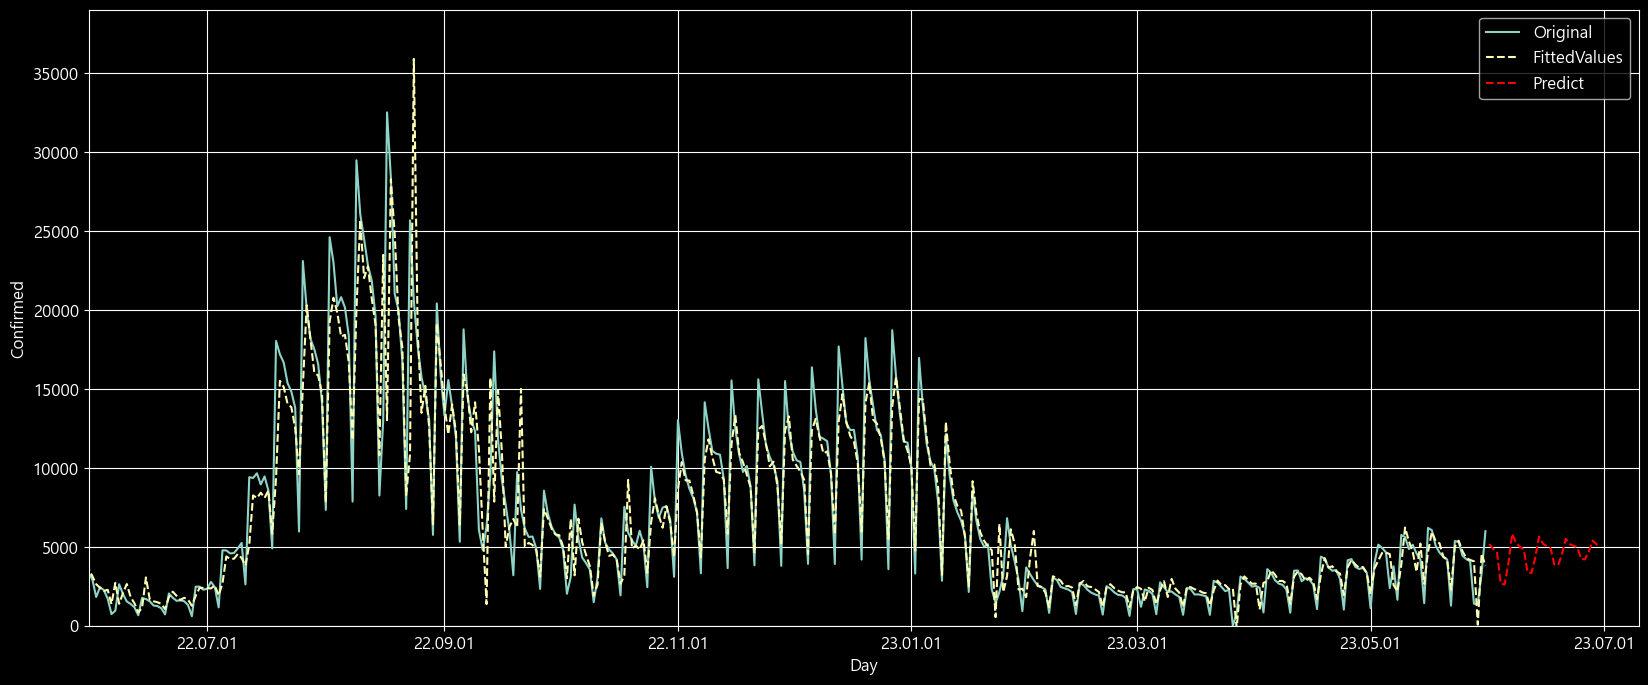

In [27]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

last = df3.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=30+10)
ymax = df3['confirmed'][xmin:xmax].max()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

In [28]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df3['confirmed'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26229.494, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=23152.696, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26427.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=23752.801, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=23793.364, Time=1.00 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=23163.519, Time=0.47 sec

Best model:  ARIMA(1,0,0)(1,0,0)[7] intercept
Total fit time: 2.371 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1212
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.348
Date:                           Mon, 07 Aug 2023   AIC                          23152.696
Time:                                   11:03:58   BIC                          23173.096
Sample:                     

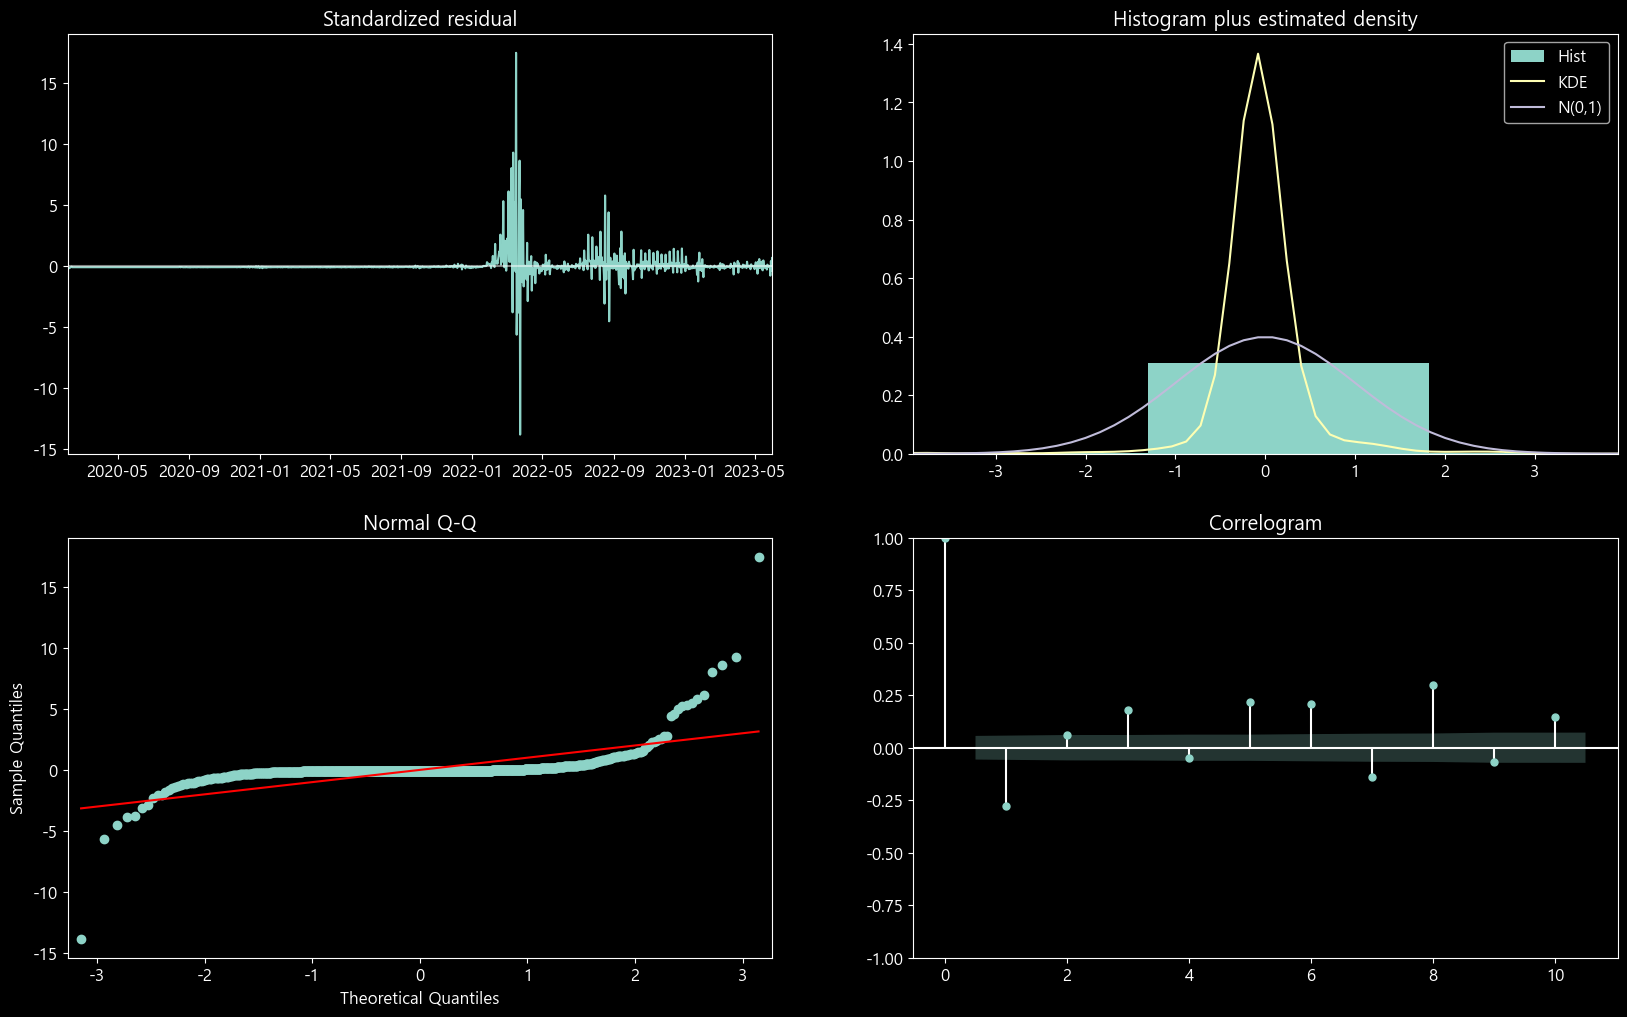

In [29]:
model.plot_diagnostics(figsize=(20,12))
plt.show()
plt.close()

In [30]:
# 여기서부터는 다ㅡㄴ거

fv = model.fittedvalues()
fv.head()

2020-02-05    4971.995254
2020-02-06    1007.070260
2020-02-07     931.477784
2020-02-08     836.685212
2020-02-09     720.039704
Freq: D, dtype: float64

In [31]:
fc = model.predict(n_period=30)
fc.head()

2023-06-01    5161.596538
2023-06-02    4859.241954
2023-06-03    4650.529336
2023-06-04    2639.199302
2023-06-05    2578.496296
Freq: D, dtype: float64

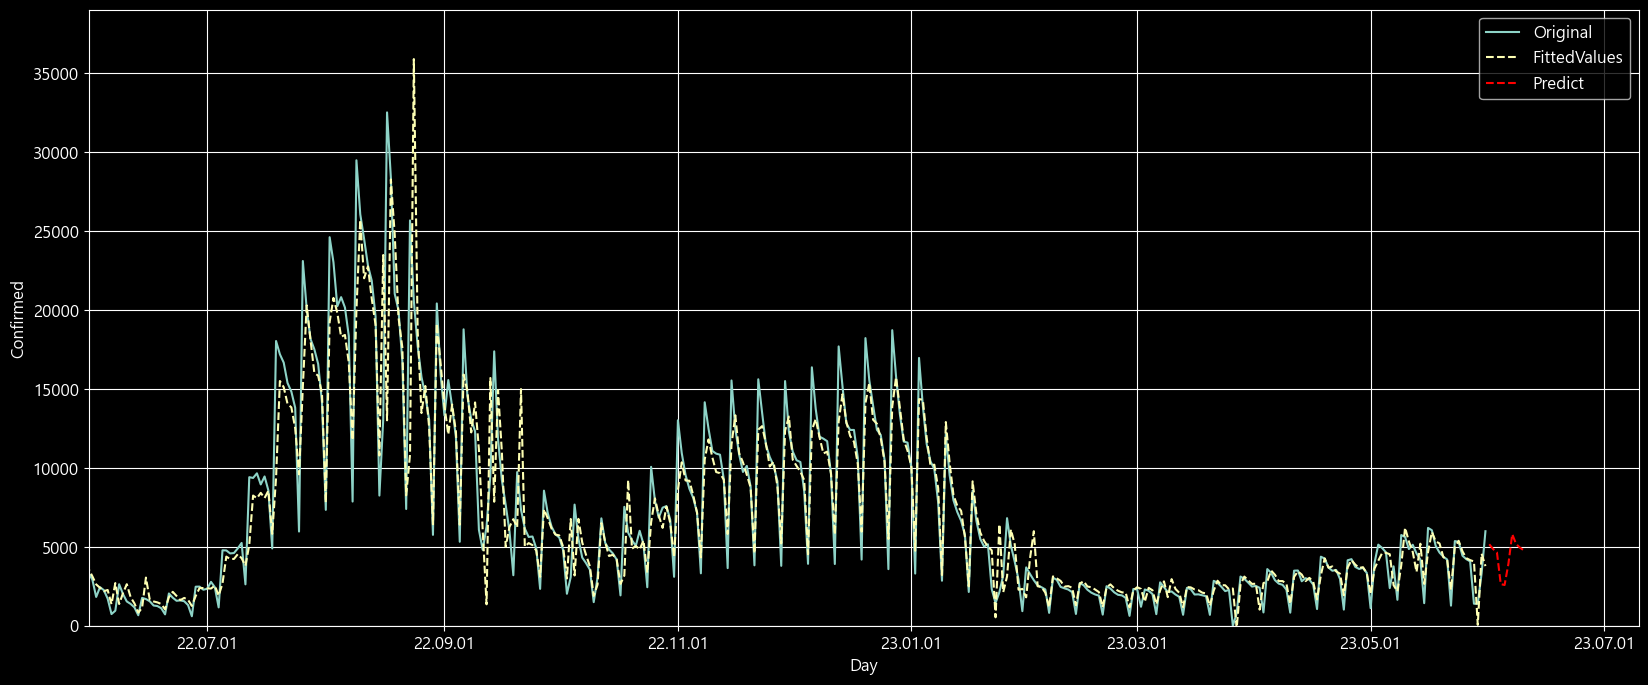

In [32]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

last = df3.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=30+10)
ymax = df3['confirmed'][xmin:xmax].max()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()